In [1]:
import pandas as pd
import numpy as np

import re
import string
import unicodedata
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, optimizers
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU,Bidirectional
from tensorflow.keras.callbacks import CSVLogger

import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [4]:
for col in df.columns[2:]:
    print(col,'\n' , df[col].value_counts())

toxic 
 0    144277
1     15294
Name: toxic, dtype: int64
severe_toxic 
 0    157976
1      1595
Name: severe_toxic, dtype: int64
obscene 
 0    151122
1      8449
Name: obscene, dtype: int64
threat 
 0    159093
1       478
Name: threat, dtype: int64
insult 
 0    151694
1      7877
Name: insult, dtype: int64
identity_hate 
 0    158166
1      1405
Name: identity_hate, dtype: int64


array([[<AxesSubplot:title={'center':'toxic'}>,
        <AxesSubplot:title={'center':'severe_toxic'}>],
       [<AxesSubplot:title={'center':'obscene'}>,
        <AxesSubplot:title={'center':'threat'}>],
       [<AxesSubplot:title={'center':'insult'}>,
        <AxesSubplot:title={'center':'identity_hate'}>]], dtype=object)

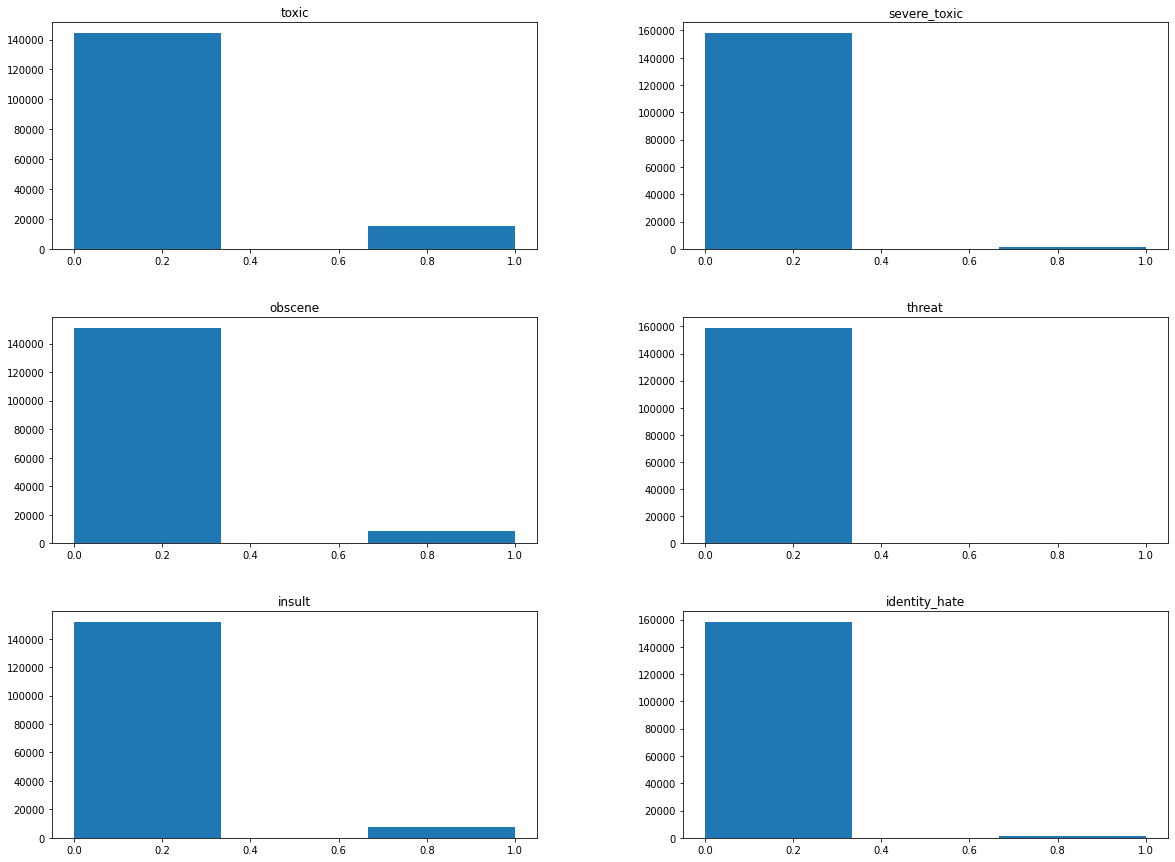

In [53]:
df.hist(figsize=(20,15),bins=3,grid=False)

In [5]:
print(df['comment_text'][np.random.randint(159571 )])

"

 January 2011 and Shii (response to message left on his talk page) 

@Reaper Eternal: Because Shii has been consistantly and arrogantly abusing his power there at Wikipedia and deserves to be treated like everyone else. POD and Shiithead are extremely biased against Mardyks because he wants the truth about 2012 to be known and they have another agenda which Mardyks keeps calling them out on. Shiithead has made comments such as ""invoking Mardyks in a dark mirror and having your soul eaten"". Very abusive fellow for a claimed Buddhist and Wiki ad. Search the records. Star Heart"


'''Sorry 

对不起 (sorry)'''

'''
subway #km, LRT #km, etc)
'''

'''
You can check the list of blocked users on the following address:

http://en.wikipedia.org/wiki/Special:Ipblocklist

'''
'''
(""Hold on to the good"" - 1 Thessalonians 5:21)
'''

# text preprocessing

In [39]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ahmed\AppData\Roaming\nltk_data...


True

In [10]:

def remove_numbers(text):
    return re.sub(r'\d+','',text)
def remove_punc(text):
    return text.translate(str.maketrans('','',string.punctuation))#'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
def lower_case(text):
    return text.lower()
def remove_non_english(text):#remove non ascci word
    return unicodedata.normalize('NFKD',text).encode('ascii','ignore').decode('utf-8','ignore')
def remove_hashtag(text):
    return re.sub(r'#\S+','',text)
def remove_links(text):
    return re.sub(r'https?://\S+','',text)
def remove_stopWords(words): # some of stop words are importantnt 'i won't hit you '
    stopWords = stopwords.words('english')
    return words.filter( lambda word : word not in stopWords)
def remove_whitespaces(text):
    return text.strip()

def stem_words(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in text.split(' ')]
def limitize_words(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text.split(' ')]

def clean_text(text):
    return remove_numbers(remove_punc(lower_case(remove_non_english(remove_hashtag(remove_links(text))))))

In [4]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [5]:
s = "Sorry 对不起 (sorry)''' ''' subway #km, LRT #km, etc)''' You can  check the 2012 list of blocked users on \
the following address: http://en.wikipedia.org/wiki/Special:Ipblocklist ''' ''' \
(Hold on to the good - 1 Thessalonians 5:21)"
s = clean_text(s)
s


'sorry  sorry  subway  lrt  etc you can  check the  list of blocked users on the following address    hold on to the good   thessalonians '

In [8]:
for w in s.split(' ') :
    print(w)

sorry

sorry

subway

lrt

etc
you
can

check
the

list
of
blocked
users
on
the
following
address



hold
on
to
the
good


thessalonians



In [4]:
df['comment_text'] =df['comment_text'].apply(clean_text)
df.head()['comment_text']

0    explanation\nwhy the edits made under my usern...
1    daww he matches this background colour im seem...
2    hey man im really not trying to edit war its j...
3    \nmore\ni cant make any real suggestions on im...
4    you sir are my hero any chance you remember wh...
Name: comment_text, dtype: object

# BOW

In [12]:
VOC_SIZE = 5000
tokenizer = Tokenizer(num_words= VOC_SIZE,split= ' ')
tokenizer.fit_on_texts(df['comment_text'])


In [11]:
print(len(tokenizer.word_index))
tokenizer.word_index

216103


{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'your': 20,
 'with': 21,
 'if': 22,
 'article': 23,
 'was': 24,
 'or': 25,
 'but': 26,
 'page': 27,
 'my': 28,
 'an': 29,
 'from': 30,
 'by': 31,
 'do': 32,
 'at': 33,
 'about': 34,
 'me': 35,
 'so': 36,
 'wikipedia': 37,
 'can': 38,
 'what': 39,
 'there': 40,
 'talk': 41,
 'all': 42,
 'has': 43,
 'will': 44,
 'please': 45,
 'would': 46,
 'its': 47,
 'no': 48,
 'one': 49,
 'just': 50,
 'like': 51,
 'they': 52,
 'he': 53,
 'dont': 54,
 'which': 55,
 'any': 56,
 'been': 57,
 'should': 58,
 'more': 59,
 'we': 60,
 'some': 61,
 'other': 62,
 'who': 63,
 'see': 64,
 'here': 65,
 'also': 66,
 'his': 67,
 'think': 68,
 'im': 69,
 'because': 70,
 'know': 71,
 'how': 72,
 'am': 73,
 'people': 74,
 'why': 75,
 'edit': 76,
 'articles': 77,
 'only': 78,
 'up': 79,
 'out': 80,
 'when': 81,
 

In [12]:
X_data = tokenizer.texts_to_matrix(df['comment_text'], mode='binary')


In [13]:
X_data.shape

(159571, 5000)

In [14]:
X_data

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
#free some momery
del(X_data)

In [6]:
Y_data = df.iloc[:,2:]
Y_data.shape

(159571, 6)

## text to sequences

In [7]:
X_sequences = tokenizer.texts_to_sequences(df['comment_text'])
sequences_pad = pad_sequences(X_sequences, maxlen=100,padding='post')

In [12]:
print(sequences_pad.shape)
sequences_pad

(159571, 100)


array([[ 638,   75,    1, ...,    0,    0,    0],
       [  53, 2441,   13, ...,    0,    0,    0],
       [ 420,  435,   69, ...,    0,    0,    0],
       ...,
       [ 374,   48,  667, ...,    0,    0,    0],
       [   4,   11,  530, ...,    0,    0,    0],
       [   4,    7,  129, ...,    0,    0,    0]])

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sequences_pad, Y_data, test_size=0.2)

In [9]:
del(sequences_pad)
del(Y_data)

In [10]:
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

# try differnet models

## LSTM

In [14]:
lstmModel = models.Sequential()
lstmModel.add(Embedding(50000+1,32,input_length = x_train.shape[1]))
lstmModel.add(LSTM(32,activation='tanh'))
lstmModel.add(Dense(64,activation = 'relu'))
lstmModel.add(Dense(32,activation = 'relu'))
lstmModel.add(Dense(6,activation = 'sigmoid'))
lstmModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           1600032   
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 1,612,742
Trainable params: 1,612,742
Non-trainable params: 0
_________________________________________________________________


In [15]:
filename='lstmlog.csv'
lstm_history_logger=CSVLogger(filename, separator=",", append=True)


In [16]:
lstmModel.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(0.001),metrics=['Accuracy'])
lstm_history = lstmModel.fit(x_train,y_train,epochs=20,batch_size=128,callbacks=[lstm_history_logger],validation_data=(x_test,y_test))


Epoch 1/20
998/998 [==============================] - 16s 10ms/step - loss: 0.1522 - Accuracy: 0.9550 - val_loss: 0.1198 - val_Accuracy: 0.9932
Epoch 2/20
998/998 [==============================] - 9s 9ms/step - loss: 0.1168 - Accuracy: 0.9944 - val_loss: 0.1155 - val_Accuracy: 0.9932
Epoch 3/20
998/998 [==============================] - 9s 9ms/step - loss: 0.1283 - Accuracy: 0.9944 - val_loss: 0.1348 - val_Accuracy: 0.9932
Epoch 4/20
998/998 [==============================] - 9s 9ms/step - loss: 0.1351 - Accuracy: 0.9944 - val_loss: 0.1359 - val_Accuracy: 0.9932
Epoch 5/20
998/998 [==============================] - 9s 9ms/step - loss: 0.1351 - Accuracy: 0.9944 - val_loss: 0.1360 - val_Accuracy: 0.9932
Epoch 6/20
998/998 [==============================] - 9s 9ms/step - loss: 0.1294 - Accuracy: 0.9944 - val_loss: 0.1034 - val_Accuracy: 0.9932
Epoch 7/20
998/998 [==============================] - 9s 9ms/step - loss: 0.1334 - Accuracy: 0.9944 - val_loss: 0.1053 - val_Accuracy: 0.9932
Epoc

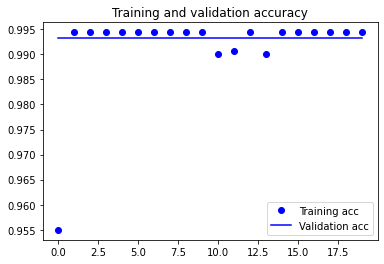

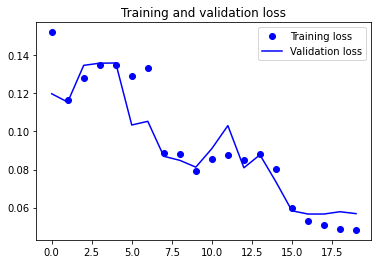

In [18]:
acc = lstm_history.history['Accuracy']
val_acc = lstm_history.history['val_Accuracy']

loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']

plt.plot( acc, 'bo', label='Training acc')
plt.plot( val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot( loss, 'bo', label='Training loss')
plt.plot( val_loss, 'b' ,label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
# save model
lstmModel.save_weights('lstmModel.h5')\
 
# load model
# lstmModelloded = lstmModel.load_weights('lstmModel.h5')\

## prediction

In [20]:
text = "you freaking ! I am going to hit you "
text = clean_text(text)
text_seq =  tokenizer.texts_to_sequences([text])
sequences_pad = pad_sequences(text_seq, maxlen=100,padding='post')

In [21]:
text_seq

[[6, 7, 73, 164, 2, 1498, 6]]

In [22]:
pred = lstmModel.predict(sequences_pad)

1/1 [==============================] - 0s 349ms/step


In [23]:
pred.shape

(1, 6)

In [24]:
pred

array([[0.6565527 , 0.00378698, 0.15981187, 0.01272053, 0.19174683,
        0.03797854]], dtype=float32)

In [25]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

## GRU

In [14]:
gruModel = models.Sequential()
gruModel.add(Embedding(50000+1,32,input_length = x_train.shape[1]))
gruModel.add(GRU(32,activation='tanh'))
gruModel.add(Dense(64,activation = 'relu'))
gruModel.add(Dense(32,activation = 'relu'))
gruModel.add(Dense(6,activation = 'sigmoid'))
gruModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           1600032   
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 1,610,758
Trainable params: 1,610,758
Non-trainable params: 0
_________________________________________________________________


In [16]:
filename='grulog.csv'
gru_history_logger=CSVLogger(filename, separator=",", append=True)

gruModel.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(0.001),metrics=['Accuracy'])
gru_history = gruModel.fit(x_train,y_train,epochs=10,batch_size=256,callbacks=[gru_history_logger],validation_data=(x_test,y_test))


Epoch 1/10
499/499 [==============================] - 8s 10ms/step - loss: 0.1545 - Accuracy: 0.8968 - val_loss: 0.0672 - val_Accuracy: 0.9942
Epoch 2/10
499/499 [==============================] - 4s 9ms/step - loss: 0.0566 - Accuracy: 0.9942 - val_loss: 0.0538 - val_Accuracy: 0.9942
Epoch 3/10
499/499 [==============================] - 4s 9ms/step - loss: 0.0508 - Accuracy: 0.9942 - val_loss: 0.0528 - val_Accuracy: 0.9942
Epoch 4/10
499/499 [==============================] - 4s 9ms/step - loss: 0.0487 - Accuracy: 0.9942 - val_loss: 0.0530 - val_Accuracy: 0.9942
Epoch 5/10
499/499 [==============================] - 4s 9ms/step - loss: 0.0471 - Accuracy: 0.9942 - val_loss: 0.0547 - val_Accuracy: 0.9942
Epoch 6/10
499/499 [==============================] - 4s 9ms/step - loss: 0.0459 - Accuracy: 0.9942 - val_loss: 0.0552 - val_Accuracy: 0.9942
Epoch 7/10
499/499 [==============================] - 4s 9ms/step - loss: 0.0446 - Accuracy: 0.9942 - val_loss: 0.0587 - val_Accuracy: 0.9942
Epoch

In [ ]:
# save model
gruModel.save_weights('grumModel.h5')\
 
# load model
# lstmModelloded = lstmModel.load_weights('lstmModel.h5')\

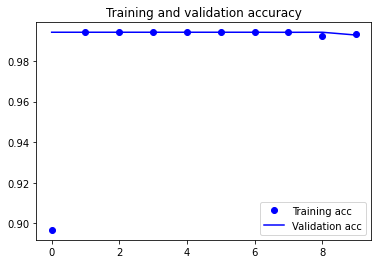

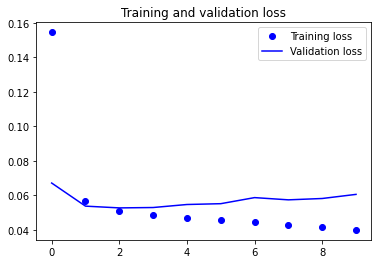

In [17]:
acc = gru_history.history['Accuracy']
val_acc = gru_history.history['val_Accuracy']

loss = gru_history.history['loss']
val_loss = gru_history.history['val_loss']

plt.plot( acc, 'bo', label='Training acc')
plt.plot( val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot( loss, 'bo', label='Training loss')
plt.plot( val_loss, 'b' ,label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Prediction

In [19]:
acc = gru_history.history['Accuracy']
val_acc = gru_history.history['val_Accuracy']

loss = gru_history.history['loss']
val_loss = gru_history.history['val_loss']

plt.plot( acc, 'bo', label='Training acc')
plt.plot( val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot( loss, 'bo', label='Training loss')
plt.plot( val_loss, 'b' ,label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

1/1 [==============================] - 0s 19ms/step


array([[0.7767696 , 0.01588654, 0.13717616, 0.03764422, 0.3813358 ,
        0.0983457 ]], dtype=float32)

In [20]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

## Bidirection LSTM

In [23]:
blstmModel = models.Sequential()
blstmModel.add(Embedding(50000+1,32,input_length = 100))
blstmModel.add(Bidirectional(LSTM(32,activation='tanh')))
blstmModel.add(Dense(64,activation = 'relu'))
blstmModel.add(Dense(32,activation = 'relu'))
blstmModel.add(Dense(6,activation = 'sigmoid'))
blstmModel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           1600032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 6)                 198       
                                                                 
Total params: 1,623,110
Trainable params: 1,623,110
Non-trainable params: 0
____________________________________________

In [17]:
filename='blstmlog.csv'
blstm_history_logger=CSVLogger(filename, separator=",", append=True)

blstmModel.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(0.001),metrics=['Accuracy'])
blstm_history = blstmModel.fit(x_train,y_train,epochs=10,batch_size=256,callbacks=[blstm_history_logger],validation_data=(x_test,y_test))


Epoch 1/10
499/499 [==============================] - 11s 16ms/step - loss: 0.1076 - Accuracy: 0.9802 - val_loss: 0.0588 - val_Accuracy: 0.9948
Epoch 2/10
499/499 [==============================] - 7s 14ms/step - loss: 0.0543 - Accuracy: 0.9940 - val_loss: 0.0540 - val_Accuracy: 0.9948
Epoch 3/10
499/499 [==============================] - 7s 14ms/step - loss: 0.0509 - Accuracy: 0.9940 - val_loss: 0.0544 - val_Accuracy: 0.9948
Epoch 4/10
499/499 [==============================] - 7s 14ms/step - loss: 0.0494 - Accuracy: 0.9935 - val_loss: 0.0541 - val_Accuracy: 0.9948
Epoch 5/10
499/499 [==============================] - 7s 14ms/step - loss: 0.0480 - Accuracy: 0.9930 - val_loss: 0.0549 - val_Accuracy: 0.9948
Epoch 6/10
499/499 [==============================] - 7s 14ms/step - loss: 0.0465 - Accuracy: 0.9905 - val_loss: 0.0548 - val_Accuracy: 0.9948
Epoch 7/10
499/499 [==============================] - 7s 14ms/step - loss: 0.0450 - Accuracy: 0.9875 - val_loss: 0.0570 - val_Accuracy: 0.994

In [24]:
# save model
# blstmModel.save_weights('blstmModel.h5')
 
# load model
lstmModelloded = blstmModel.load_weights('blstmModel.h5')

In [ ]:
blstmModel

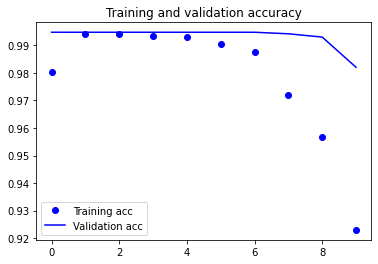

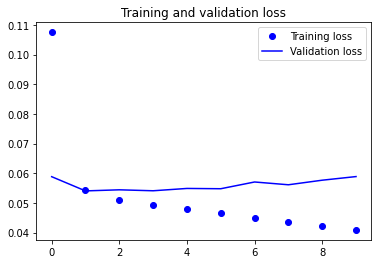

In [19]:
acc = blstm_history.history['Accuracy']
val_acc = blstm_history.history['val_Accuracy']

loss = blstm_history.history['loss']
val_loss = blstm_history.history['val_loss']

plt.plot( acc, 'bo', label='Training acc')
plt.plot( val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot( loss, 'bo', label='Training loss')
plt.plot( val_loss, 'b' ,label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Prediction

In [29]:
text = "you freaking awesome  "
text = clean_text(text)
text_seq =  tokenizer.texts_to_sequences([text])
sequences_pad = pad_sequences(text_seq, maxlen=100,padding='post')

pred = blstmModel.predict(sequences_pad)
pred

1/1 [==============================] - 0s 20ms/step


array([[0.01172782, 0.00029293, 0.00920225, 0.00018134, 0.0049391 ,
        0.00083248]], dtype=float32)

In [30]:
(pred >= 0.5).astype(int)

array([[0, 0, 0, 0, 0, 0]])

In [31]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

## Bidirectional GRU

In [11]:
bgruModel = models.Sequential()
bgruModel.add(Embedding(50000+1,32,input_length = x_train.shape[1]))
bgruModel.add(Bidirectional(GRU(32,activation='tanh')))
bgruModel.add(Dense(64,activation = 'relu'))
bgruModel.add(Dense(32,activation = 'relu'))
bgruModel.add(Dense(6,activation = 'sigmoid'))
bgruModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           1600032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12672     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 1,619,142
Trainable params: 1,619,142
Non-trainable params: 0
______________________________________________

In [12]:
filename='grulog.csv'
bgru_history_logger=CSVLogger(filename, separator=",", append=True)

bgruModel.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(0.001),metrics=['Accuracy'])
bgru_history = bgruModel.fit(x_train,y_train,epochs=10,batch_size=256,callbacks=[bgru_history_logger],validation_data=(x_test,y_test))


Epoch 1/10
499/499 [==============================] - 11s 15ms/step - loss: 0.1079 - Accuracy: 0.9060 - val_loss: 0.0610 - val_Accuracy: 0.9941
Epoch 2/10
499/499 [==============================] - 7s 13ms/step - loss: 0.0547 - Accuracy: 0.9942 - val_loss: 0.0572 - val_Accuracy: 0.9941
Epoch 3/10
499/499 [==============================] - 7s 13ms/step - loss: 0.0519 - Accuracy: 0.9942 - val_loss: 0.0544 - val_Accuracy: 0.9941
Epoch 4/10
499/499 [==============================] - 7s 13ms/step - loss: 0.0494 - Accuracy: 0.9942 - val_loss: 0.0545 - val_Accuracy: 0.9941
Epoch 5/10
499/499 [==============================] - 7s 13ms/step - loss: 0.0479 - Accuracy: 0.9942 - val_loss: 0.0543 - val_Accuracy: 0.9941
Epoch 6/10
499/499 [==============================] - 7s 13ms/step - loss: 0.0467 - Accuracy: 0.9942 - val_loss: 0.0538 - val_Accuracy: 0.9941
Epoch 7/10
499/499 [==============================] - 7s 13ms/step - loss: 0.0452 - Accuracy: 0.9941 - val_loss: 0.0543 - val_Accuracy: 0.993

In [13]:
# save model
# bgruModel.save_weights('bgruModel.h5')\
 
# load model
# lstmModelloded = lstmModel.load_weights('bgruModel.h5')

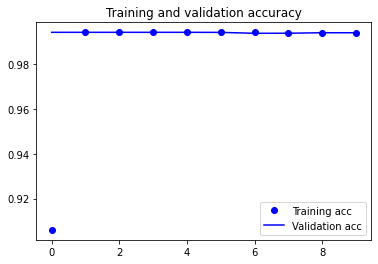

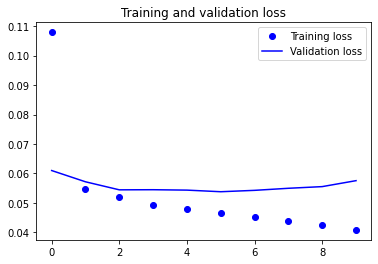

In [14]:
acc = bgru_history.history['Accuracy']
val_acc = bgru_history.history['val_Accuracy']

loss = bgru_history.history['loss']
val_loss = bgru_history.history['val_loss']

plt.plot( acc, 'bo', label='Training acc')
plt.plot( val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot( loss, 'bo', label='Training loss')
plt.plot( val_loss, 'b' ,label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Prediction

In [15]:
text = "you freaking bad ! I am going to hit you "
text = clean_text(text)
text_seq =  tokenizer.texts_to_sequences([text])
sequences_pad = pad_sequences(text_seq, maxlen=100,padding='post')

pred = bgruModel.predict(sequences_pad)
pred

1/1 [==============================] - 0s 441ms/step


array([[0.7075781 , 0.02198998, 0.12445681, 0.06636558, 0.26061437,
        0.09349374]], dtype=float32)

In [ ]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [32]:
test_df = pd.read_csv('test.csv')
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [33]:
test_df['comment_text'] =test_df['comment_text'].apply(clean_text)
test_df

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule is more succesful then youll ...
1,0000247867823ef7,from rfc \n\n the title is fine as it is imo
2,00013b17ad220c46,\n\n sources \n\n zawe ashton on lapland
3,00017563c3f7919a,if you have a look back at the source the info...
4,00017695ad8997eb,i dont anonymously edit articles at all
...,...,...
153159,fffcd0960ee309b5,\n i totally agree this stuff is nothing but ...
153160,fffd7a9a6eb32c16,throw from out field to home plate \n\n does...
153161,fffda9e8d6fafa9e,\n\n okinotorishima categories \n\n i see y...
153162,fffe8f1340a79fc2,\n\n one of the founding nations of the eu ...


In [37]:
test_df_seq =  tokenizer.texts_to_sequences(test_df['comment_text'])
sequences_pad = pad_sequences(test_df_seq, maxlen=100,padding='post')



In [39]:
pred = blstmModel.predict(sequences_pad)
pred

4787/4787 [==============================] - 16s 3ms/step


array([[5.1329426e-02, 5.4089483e-05, 3.7589371e-03, 8.2316255e-05,
        3.0933556e-03, 3.8074219e-04],
       [5.5037055e-04, 1.1396821e-06, 1.5029845e-04, 8.4506337e-07,
        6.2783081e-05, 6.5837612e-06],
       [2.0725934e-02, 1.9865339e-04, 6.4424383e-03, 2.2384280e-04,
        4.4748201e-03, 9.6397166e-04],
       ...,
       [4.6900465e-04, 5.3894854e-07, 9.6031239e-05, 3.7010957e-07,
        4.3881882e-05, 3.2361349e-06],
       [5.2023637e-01, 9.3046541e-04, 5.1990893e-02, 1.8918837e-03,
        5.5118088e-02, 7.2190259e-03],
       [7.6257229e-01, 7.0310347e-03, 1.1275840e-01, 1.9584537e-02,
        2.4556752e-01, 6.4149454e-02]], dtype=float32)

In [41]:
pred.shape

(153164, 6)

In [42]:
pred = (pred >=0.5).astype(int)

In [44]:
result_df = pd.DataFrame(pred,columns=df.columns[2:])
Test_output = pd.concat([test_df,result_df],axis=1)
Test_output.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,yo bitch ja rule is more succesful then youll ...,0,0,0,0,0,0
1,0000247867823ef7,from rfc \n\n the title is fine as it is imo,0,0,0,0,0,0
2,00013b17ad220c46,\n\n sources \n\n zawe ashton on lapland,0,0,0,0,0,0
3,00017563c3f7919a,if you have a look back at the source the info...,0,0,0,0,0,0
4,00017695ad8997eb,i dont anonymously edit articles at all,0,0,0,0,0,0


In [45]:
Test_output.to_csv('Test_output.csv',index=False)